# Autotuning and analyzing SQLite with MLOS demo

In this notebook, we look at the data from 100 configs we ran in `mlos_bench` to find a better SQLite configuration.

### 1. Data collection

We use the following commands in the integrated terminal of this codespace:

```sh
conda activate mlos

mlos_bench --config config/cli/local-sqlite-opt.jsonc \
           --globals config/experiments/sqlite-sync-journal-pagesize-caching-experiment.jsonc \
           --trial-config-repeat-count 3 \
           --max-iterations 100
```

> See Also: [README.md](./README.md) for further instructions.

Now we can start analyzing the autotuning data produced by running the benchmark trials.

### 2. Import MLOS packages

In [2]:
# Import mlos_bench Storage API to access the experimental data.
from mlos_bench.storage import from_config

### 3. Connect to the DB using existing mlos_bench configs

In [3]:
storage = from_config(config_file="storage/sqlite.jsonc")

### 4. Load the data for our experiment

In [4]:
storage.experiments

{'mysql-innodb-bseries-v346-vmcontrol': Experiment :: mysql-innodb-bseries-v346-vmcontrol: 'Azure MySQL+Sysbench Root',
 'mysql-innodb-buf': Experiment :: mysql-innodb-buf: 'Azure MySQL+Sysbench Root',
 'mysql-innodb-explore-D2S': Experiment :: mysql-innodb-explore-D2S: 'Azure MySQL+Sysbench Root',
 'sqlite-opt-demo': Experiment :: sqlite-opt-demo: 'SQLite3 BenchBase Local',
 'sqlite-opt-demo-1': Experiment :: sqlite-opt-demo-1: 'SQLite3 BenchBase Local',
 'sqlite-opt-demo-1-nosync': Experiment :: sqlite-opt-demo-1-nosync: 'SQLite3 BenchBase Local',
 'sqlite-sync-journal-pagesize-caching-experiment': Experiment :: sqlite-sync-journal-pagesize-caching-experiment: 'sqlite-local-benchbase'}

We see a record for our experiment in the DB. Let's look at the data associated with it.

In [5]:
experiment_id = "sqlite-opt-demo-1"

### 5. Get all data for one experiment

In [6]:
exp = storage.experiments[experiment_id]

In [7]:
# Display the set of optimization target objectives.
exp.objectives

{'90th Percentile Latency (microseconds)': 'min'}

The main method that combines the information about each trial along with the trial configuration parameters and its results, is the property `.results_df`.

It conveniently returns all data about the experiment is a single Pandas DataFrame.

In [8]:
# View some of the result data associated with that experiment.
df = exp.results_df
df.head()

,trial_id,ts_start,ts_end,tunable_config_id,tunable_config_trial_group_id,status,config.cache_size,config.journal_mode,config.journal_size_limit,config.mmap_size,...,result.Socket messages sent,result.Start timestamp (milliseconds),result.Swaps,result.System time (seconds),result.Throughput (requests/second),result.User time (seconds),result.Voluntary context switches,result.isolation,result.scalefactor,result.terminals
0,1,2024-01-26 22:53:49.523854,2024-01-26 22:54:02.728706,707,1,SUCCEEDED,1,delete,-1,-1,...,0.0,1.706310e+12,0.0,1.62,38.299629,4.73,125282.0,TRANSACTION_SERIALIZABLE,1.0,1.0
1,2,2024-01-26 22:54:02.751738,2024-01-26 22:54:15.885070,707,1,SUCCEEDED,1,delete,-1,-1,...,0.0,1.706310e+12,0.0,1.50,39.399672,4.65,118462.0,TRANSACTION_SERIALIZABLE,1.0,1.0
2,3,2024-01-26 22:54:15.906278,2024-01-26 22:54:29.185711,707,1,SUCCEEDED,1,delete,-1,-1,...,0.0,1.706310e+12,0.0,1.60,42.099704,4.71,121347.0,TRANSACTION_SERIALIZABLE,1.0,1.0
3,4,2024-01-26 22:54:29.223920,2024-01-26 22:54:42.557596,708,4,SUCCEEDED,1656398469,truncate,-1,1101955984,...,0.0,1.706310e+12,0.0,4.06,1493.585690,14.75,116795.0,TRANSACTION_SERIALIZABLE,1.0,1.0
4,5,2024-01-26 22:54:42.589275,2024-01-26 22:54:56.419469,708,4,SUCCEEDED,1656398469,truncate,-1,1101955984,...,0.0,1.706310e+12,0.0,3.85,1595.590499,15.31,116042.0,TRANSACTION_SERIALIZABLE,1.0,1.0


Each record of the DataFrame has the information about the trial, e.g., its timestamp and status, along with the configuration parameters (columns prefixed with `config.`) and the benchmark results (columns prefixed with `result.`). The `trial_id` field is simply the iteration number within the current experiment. Let's look at the first record to see all these fields.

In [9]:
df.loc[1]

trial_id                                                                                              2
ts_start                                                                     2024-01-26 22:54:02.751738
ts_end                                                                       2024-01-26 22:54:15.885070
tunable_config_id                                                                                   707
tunable_config_trial_group_id                                                                         1
status                                                                                        SUCCEEDED
config.cache_size                                                                                     1
config.journal_mode                                                                              delete
config.journal_size_limit                                                                            -1
config.mmap_size                                                

### 6. Visualize the results data automatically using `mlos_viz.plot()`

In [10]:
import mlos_viz

`mlos_viz` attempts to use the information about the data to automatically provide some basic visualizations without much effort on the developer's part.

At the moment, we do this using [`dabl`](https://github.com/dabl/dabl), though in the future we intend to add support for more interactive visualizations or even scheduling new trials, while maintaining a very simple API:

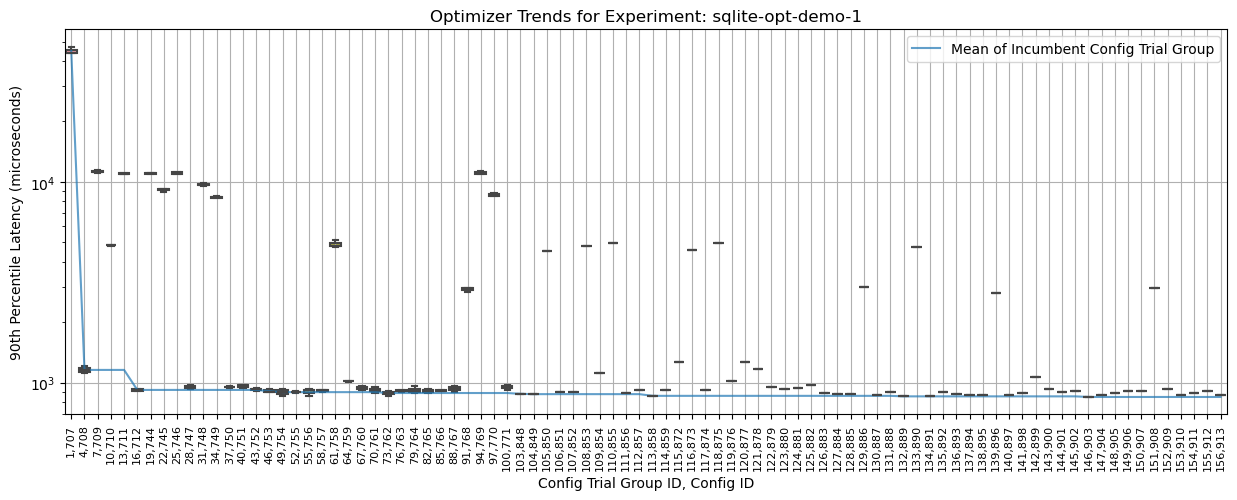

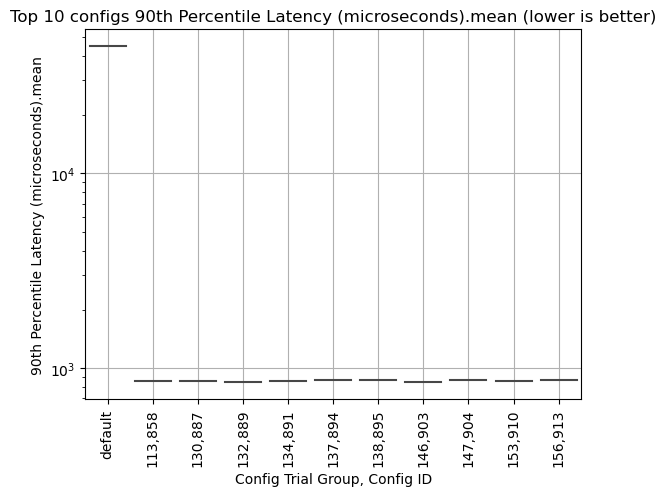

Target looks like regression


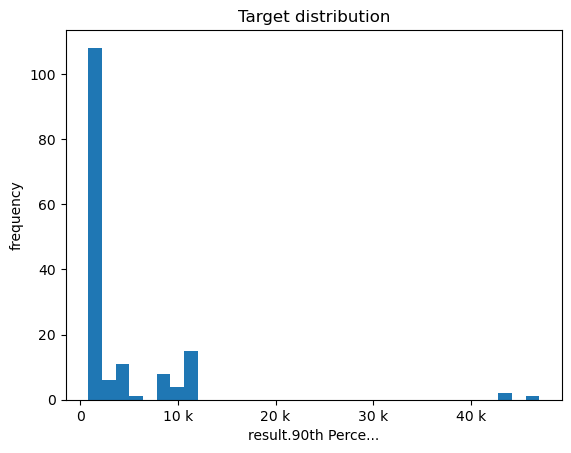

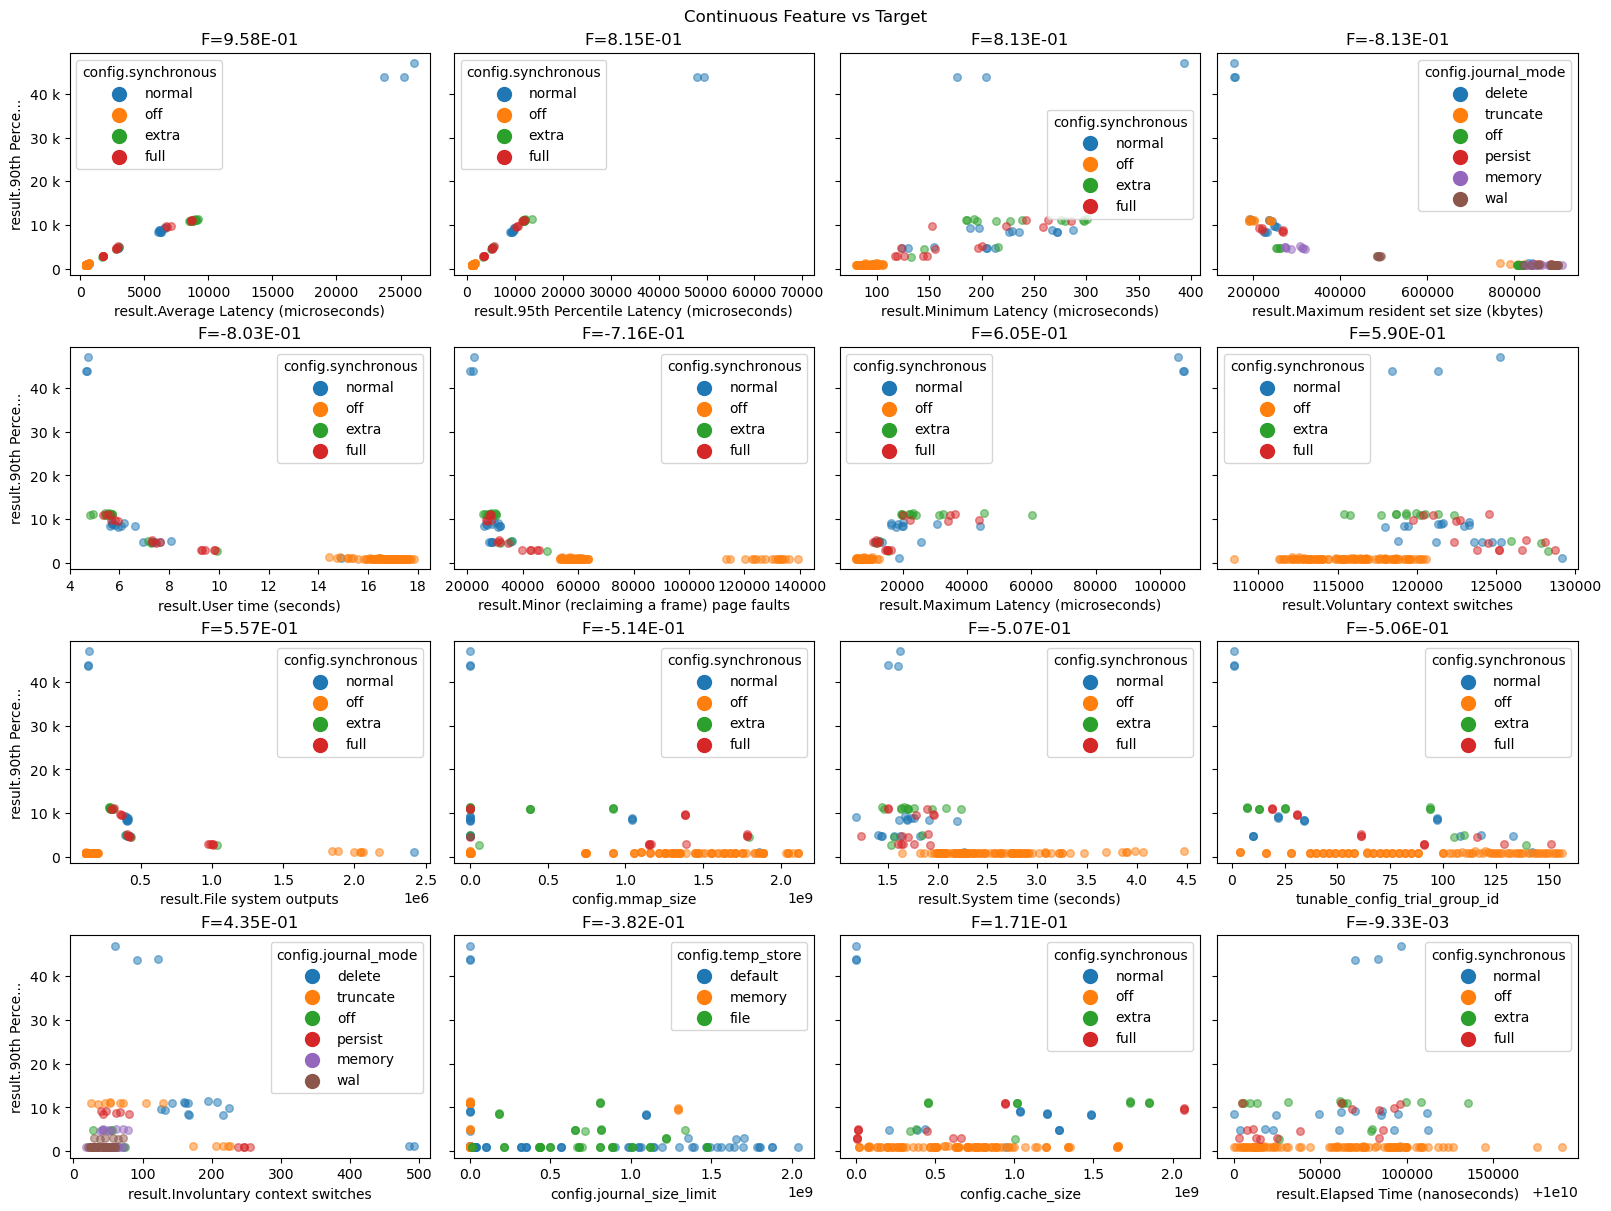

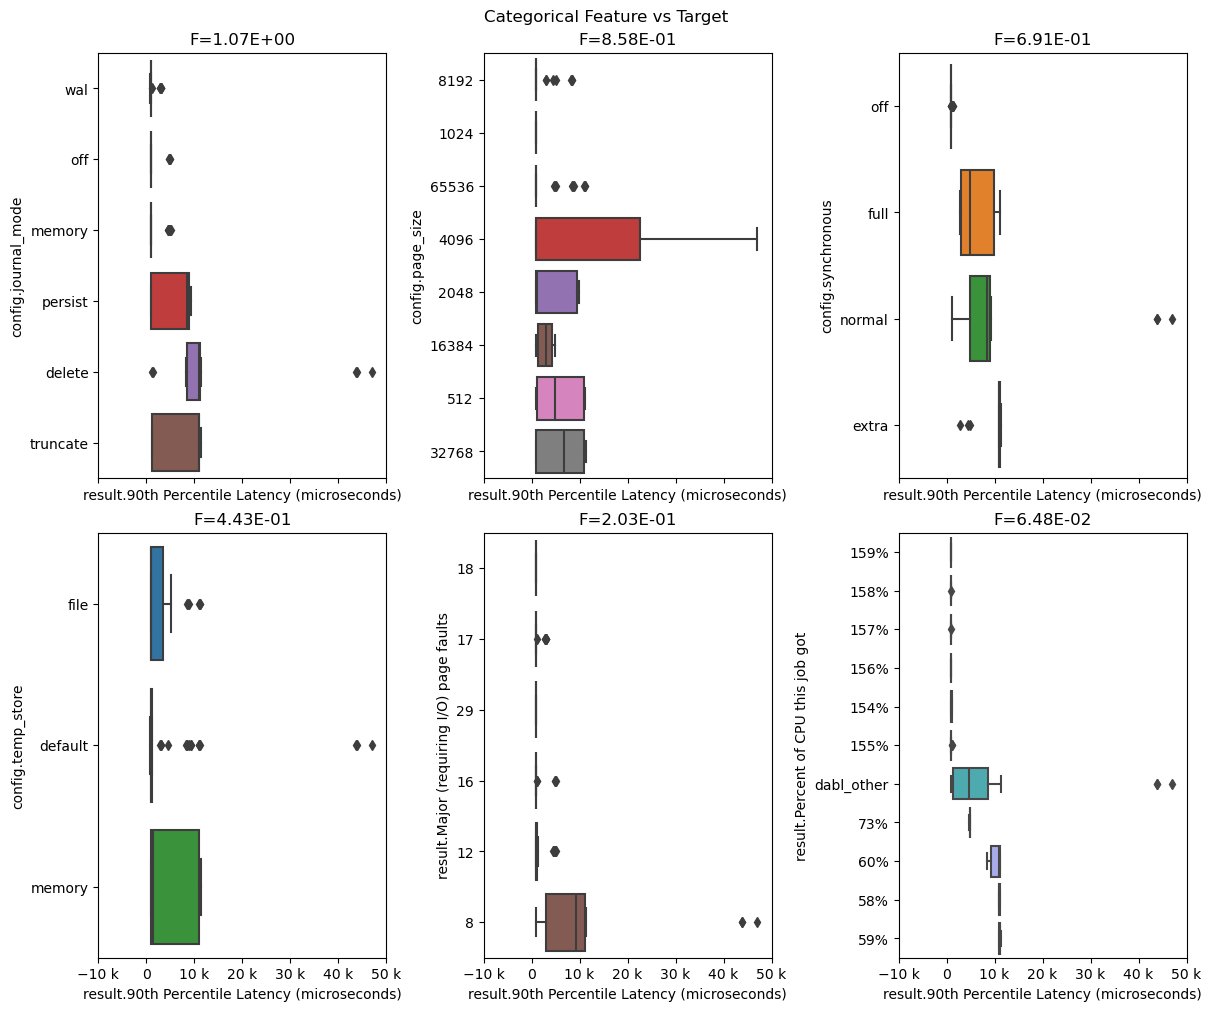

In [17]:
mlos_viz.plot(exp)

### 8. Refocusing on a new region of the config space

After examining the results visualized above, we can see that the optimizer discovered that we're able to achieve lower 90th percentile latency by disabling synchronous writes.

However, this may be a poor idea for some application scenarios where data durability is important.

Let's see if we can find a better configuration that still has synchronous writes enabled by adjusting our configurations to exclude that parameter from the search space.

We can rerun with a new experiment ID and prewarm the optimizer with trials that match this new configuration subspace.

```sh
# Rerun with a new config that has nosync disabled.
mlos_bench --config config/cli/local-sqlite-opt.jsonc \
           --globals config/experiments/sqlite-journal-pagesize-caching-experiment.jsonc \
```

In [12]:
### Reanalyze the new data

experiment_id = "sqlite-opt-demo-1-nosync"
exp_nosync = storage.experiments[experiment_id]

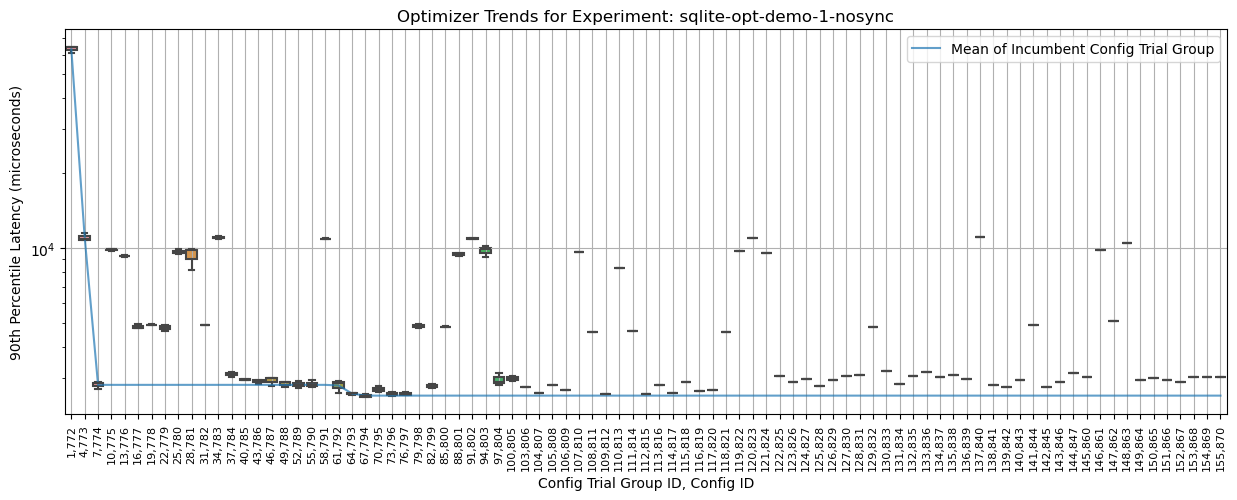

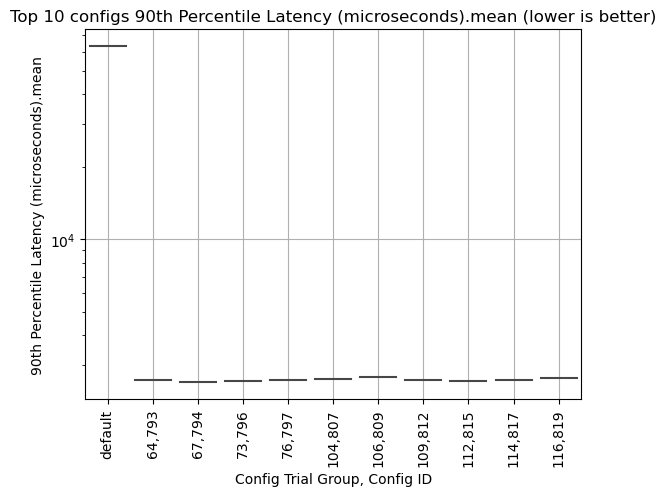

Target looks like regression


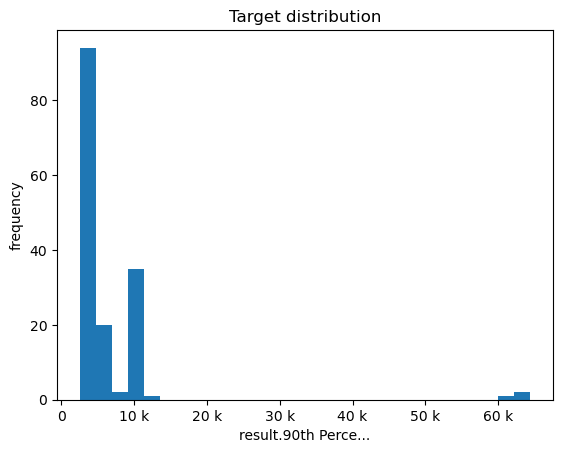

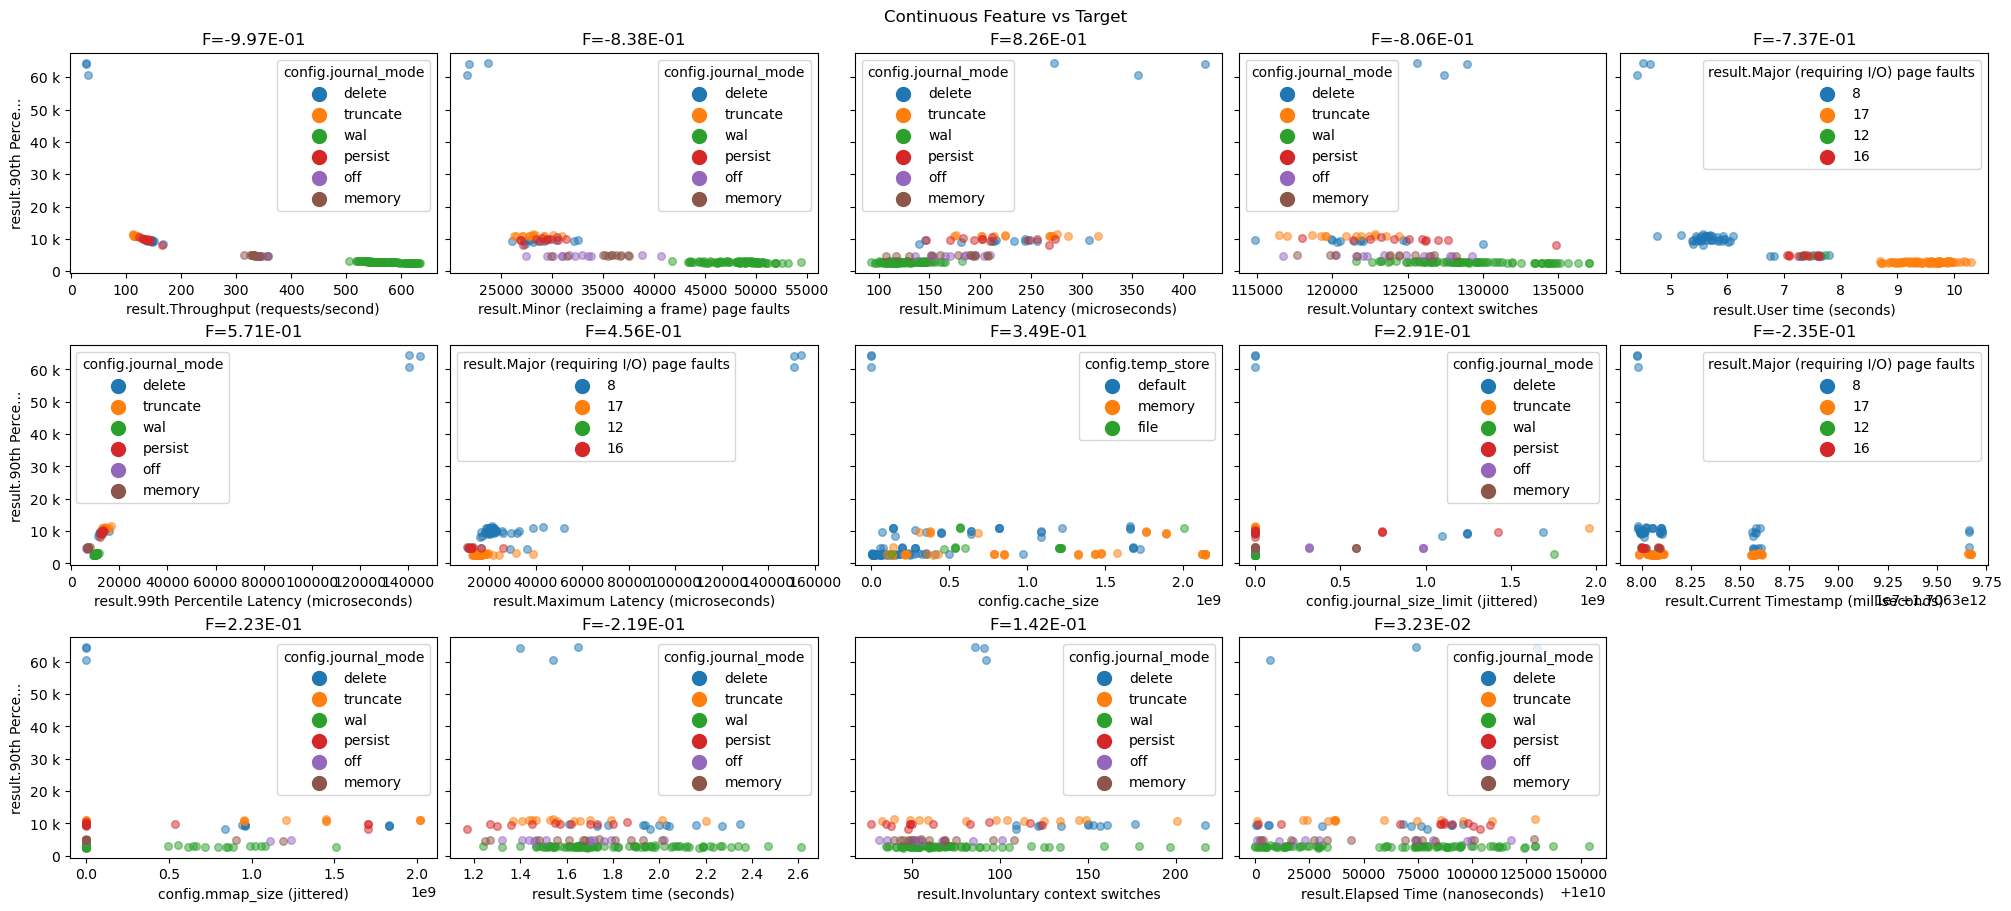

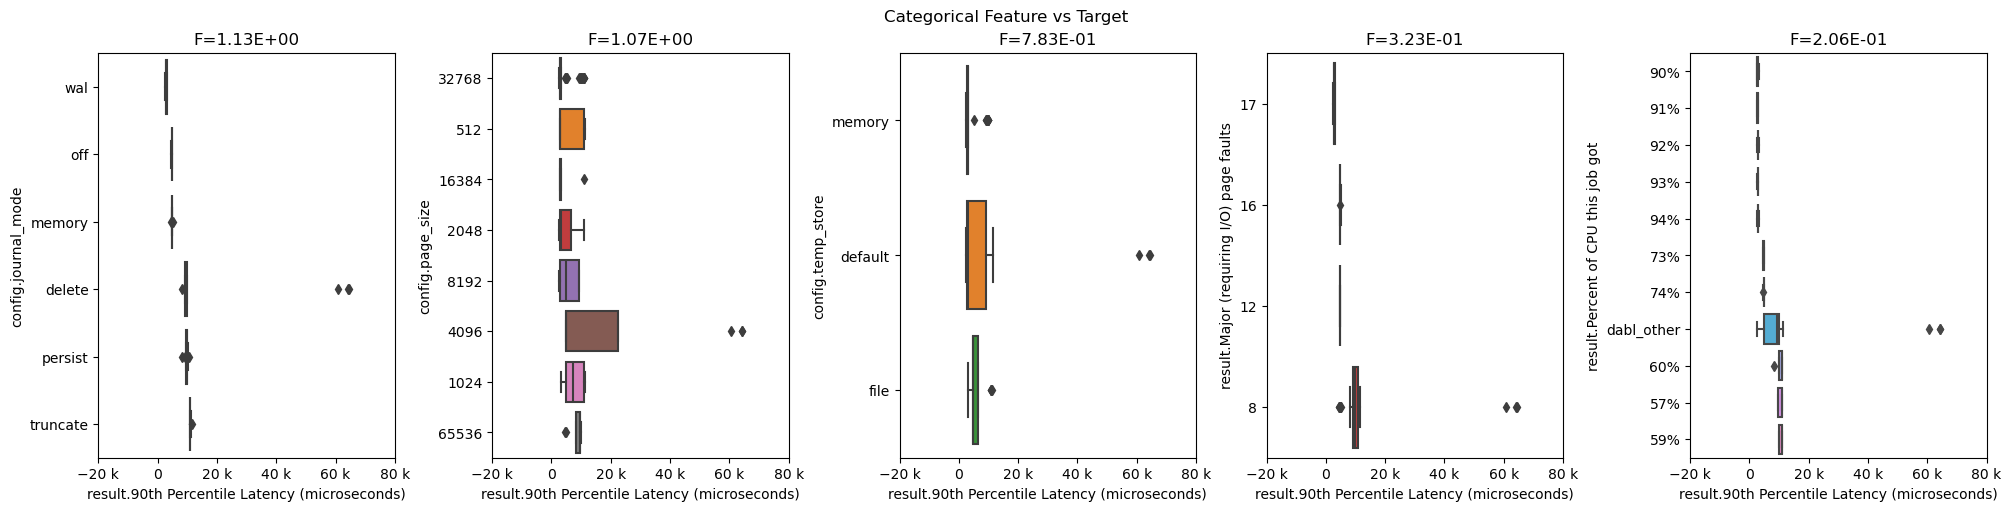

In [19]:
mlos_viz.plot(exp_nosync)

#### Analyzing the results in tabular form.

We can also use utility functions provided by `mlos_viz` to extract the top-N configs from the results, based on the original or a new objective metric.

Display the default config's performance:


,result.99th Percentile Latency (microseconds).mean
0,101738.0


Display the best config seen with tunable configs including sync settings:


,result.99th Percentile Latency (microseconds).mean
51,1534.666667


Display the best config seen with tunable configs excluding sync settings:


,result.99th Percentile Latency (microseconds).mean
110,6467.0


<Axes: >

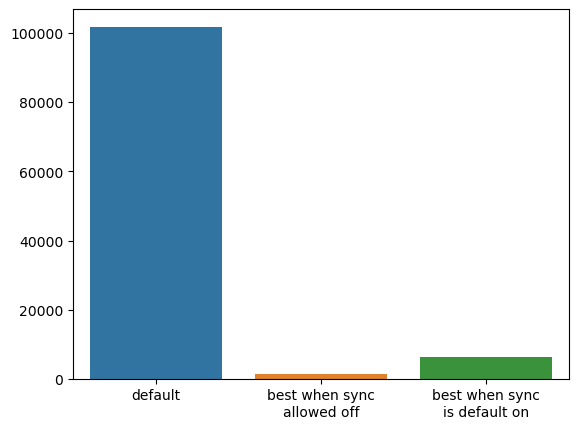

In [33]:
top_n = 1
alt_result_objectives = {"99th Percentile Latency (microseconds)": "min"}
(top_n_configs_df, top_n_config_ids, orderby_cols) = mlos_viz.limit_top_n_configs(
    exp,
    top_n_configs=top_n,
    objectives=alt_result_objectives,
)
(top_n_configs_nosync_df, top_n_config_ids_nosync, orderby_cols) = mlos_viz.limit_top_n_configs(
    exp_nosync,
    top_n_configs=top_n,
    objectives=alt_result_objectives,
)

def display_config_group_result(results_df, config_group_id):
    cols = list(orderby_cols.keys())
    df = results_df.loc[results_df["tunable_config_id"] == config_group_id][cols].head(1)
    display(df)
    return df[cols[0]].iloc[0]

print("Display the default config's performance:")
default = display_config_group_result(top_n_configs_df, top_n_config_ids[0])

print("Display the best config seen with tunable configs including sync settings:")
best_with_sync_tunable = display_config_group_result(top_n_configs_df, top_n_config_ids[1])

print("Display the best config seen with tunable configs excluding sync settings:")
best_with_sync_default = display_config_group_result(top_n_configs_nosync_df, top_n_config_ids_nosync[1])

import seaborn as sns
import matplotlib.pyplot as plt

sns.barplot(
    x=["default", "best when sync\nallowed off", "best when sync\nis default on"],
    y=[default, best_with_sync_tunable, best_with_sync_default],
)
#plt.yscale("log")

<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>

### MLOS a tool for benchmark automation data gathering and autotuning

Thank you for watching!

Please visit us at <https://aka.ms/MLOS> to learn more.


<br/>
<br/>
<br/>
<br/>
<br/>
<br/>
<br/>